# Generative Adversial Neural Network for Galaxy Image Generation

## 1. Dataset

In [39]:
import tensorflow as tf
import keras
import numpy as np
from matplotlib import pyplot as plt
import os

In [40]:
dataset_path = 'dataset/'
dataset_files = np.array([f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'jpg' in file])[:20000]

In [41]:
dataset_files

array(['dataset//877039.jpg', 'dataset//274957.jpg',
       'dataset//175708.jpg', ..., 'dataset//402416.jpg',
       'dataset//816608.jpg', 'dataset//851353.jpg'], dtype='<U19')

In [42]:
from PIL import Image

In [43]:
class ImagesBatchGenerator(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, batch_size, image_size, load_all=False):
        self.dataset_files = dataset_files
        self.batch_size = batch_size
        self.image_size = image_size
        self.load_all = load_all
        
        if self.load_all:
            for i in range(0, len(self.dataset_files), self.batch_size):
                subset = self.dataset_files[i:i+self.batch_size]
                temp_batch = np.array([[np.expand_dims(np.asarray(Image.open(path).convert('L').resize(self.image_size))/255, 2) for path in subset]])
                if i==0:
                    self.dataset = temp_batch
                else:
                    self.dataset = np.append(self.dataset, temp_batch, axis=0)
            
    
    def __len__(self):
        return len(self.dataset_files) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        if not self.load_all:
            # Read and return
            return np.array([np.asarray(Image.open(path).convert('L').resize(self.image_size)) / 255 for path in subset])
        else: 
            return self.dataset[idx]
    
    
    def show_subset(self, idx, ncols=4):
        images = self.__getitem__(idx)
        
        fig, ax = plt.subplots(ncols=ncols, figsize=(20,20))
        for i in range(4):
            ax[i].imshow(np.squeeze(images[i]))
            ax[i].title.set_text(i)

In [44]:
real_images = ImagesBatchGenerator(dataset_files, batch_size=200, image_size=(64,64), load_all=True)

In [45]:
real_images.__getitem__(0).shape

(200, 64, 64, 1)

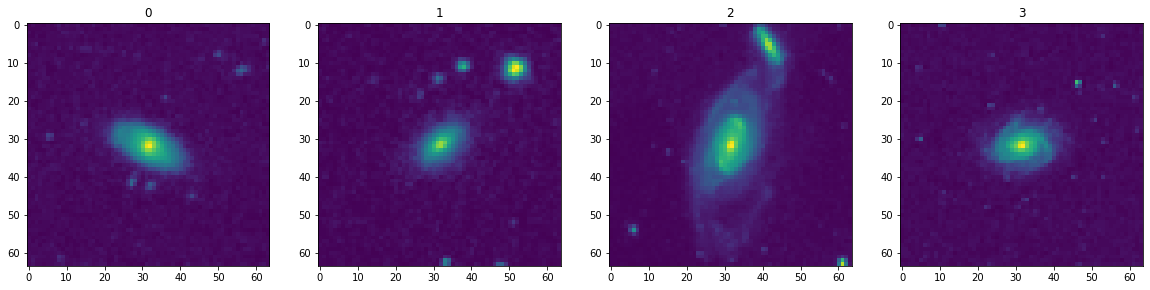

In [46]:
real_images.show_subset(2)

## 2. Build Neural Networks

### 2.1. Import Modelling Components

In [47]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 2.2. Build Generator

In [48]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1,4,padding='same', activation='sigmoid'))
    
    return model

In [49]:
generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              1056768   
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                      

In [50]:
img = generator.predict(np.random.randn(4,128,1))
img

1/1 [==============================] - 0s 74ms/step


array([[[[0.4991434 ],
         [0.49902654],
         [0.49997938],
         ...,
         [0.49706075],
         [0.49859804],
         [0.49959788]],

        [[0.49789023],
         [0.49668103],
         [0.49853545],
         ...,
         [0.4979121 ],
         [0.49879593],
         [0.49949172]],

        [[0.4987152 ],
         [0.49774405],
         [0.4976178 ],
         ...,
         [0.4967427 ],
         [0.5004734 ],
         [0.5002672 ]],

        ...,

        [[0.496084  ],
         [0.49496937],
         [0.49544922],
         ...,
         [0.50061315],
         [0.49942368],
         [0.50185335]],

        [[0.49826795],
         [0.4974693 ],
         [0.49762124],
         ...,
         [0.49939063],
         [0.49961776],
         [0.50039166]],

        [[0.49849048],
         [0.49881595],
         [0.4978381 ],
         ...,
         [0.5002022 ],
         [0.5008633 ],
         [0.50081724]]],


       [[[0.49720517],
         [0.5011522 ],
         [0.50

1/1 [==============================] - 0s 15ms/step


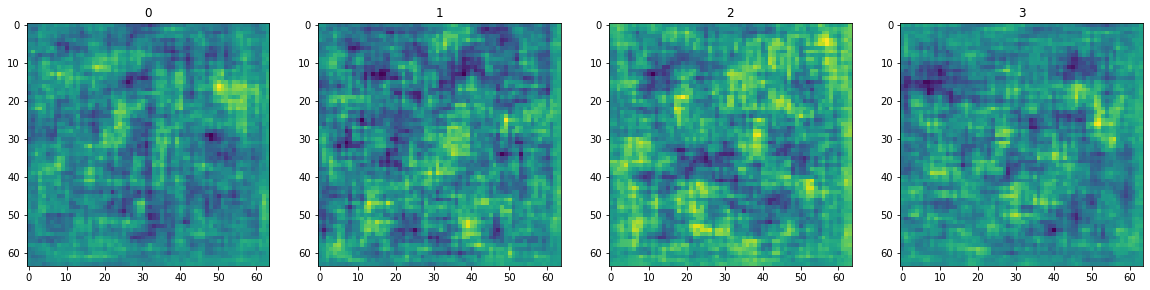

In [51]:
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, im in enumerate(img):
    ax[idx].imshow(np.squeeze(im))
    ax[idx].title.set_text(idx)

### 2.3. Build Discriminator

In [52]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(64,64,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [53]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 60, 60, 32)        832       
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 60, 60, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 60, 60, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 56, 56, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 128)      

In [54]:
img.shape

(4, 64, 64, 1)

In [55]:
discriminator.predict(img)

1/1 [==============================] - 0s 51ms/step


array([[0.5004653 ],
       [0.50047237],
       [0.5003951 ],
       [0.50049096]], dtype=float32)

In [56]:
generator.load_weights('models/generator')
discriminator.load_weights('models/discriminator')

2022-11-06 10:01:49.331450: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/generator: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?
2022-11-06 10:01:49.349679: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open models/discriminator: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


In [75]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 16ms/step


In [76]:
discriminator.predict(img)

1/1 [==============================] - 0s 17ms/step


array([[0.99999976],
       [0.99999976],
       [0.99999976],
       [0.99999976]], dtype=float32)

In [77]:
discriminator.predict(real_images.__getitem__(0)[:4])

1/1 [==============================] - 0s 15ms/step


array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [78]:
yhat_real = discriminator(real_images.__getitem__(0)[:4], training=True) # Should be all zeros
yhat_fake = discriminator(fake_images, training=True) # Should be all ones
yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

# Create labels for real and fake images
y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

TypeError: Inputs to a layer should be tensors. Got: <__main__.ImagesBatchGenerator object at 0x7faeff6b9850>

## 3. Training Loop

### 3.1. Losses and Optimzizers

In [59]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [60]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 3.2. Custom Model

In [61]:
from keras.models import Model

Input example

In [62]:
tf.random.normal((6, 128, 1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.46141207e+00],
        [ 5.68333805e-01],
        [ 1.70381820e+00],
        [-1.33008564e+00],
        [ 1.20359838e+00],
        [ 5.58634758e-01],
        [-1.04929709e+00],
        [ 1.30996835e+00],
        [-7.82635927e-01],
        [ 2.42261720e+00],
        [ 1.36178777e-01],
        [ 4.18184966e-01],
        [-5.36141396e-01],
        [ 1.51367649e-01],
        [ 1.36219716e+00],
        [-5.80015555e-02],
        [ 8.40083599e-01],
        [-7.50243604e-01],
        [ 1.19795799e+00],
        [ 5.12193501e-01],
        [-1.84500273e-02],
        [-4.45459366e-01],
        [ 5.26701398e-02],
        [-1.17102444e+00],
        [ 8.13448966e-01],
        [-1.36252820e+00],
        [-1.20075989e+00],
        [ 9.41068470e-01],
        [-8.27499270e-01],
        [-5.83817124e-01],
        [-8.35041761e-01],
        [ 7.77322710e-01],
        [-6.00419164e-01],
        [-3.20098162e-01],
        [-5.84807396e-02],
  

In [63]:
class GalaxyGAN(Model):
    def __init__(self, generator, discriminator, batch_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self, batch):
        # Get data
        real_images = batch
        fake_images = self.generator(tf.random.normal((self.batch_size, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) # Should be all zeros
            yhat_fake = self.discriminator(fake_images, training=True) # Should be all ones
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fake images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
        
            # Add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0) 
            
            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagtion - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((self.batch_size,128,1)), training=True)
            
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            # Calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}
            

Load model from h5 foramt

In [64]:
# generator = keras.models.load_model('models/generator.h5')
# discriminator = keras.models.load_model('models/discriminator.h5')

In [65]:
galaxy_gan = GalaxyGAN(generator, discriminator, batch_size=200)

1/1 [==============================] - 0s 188ms/step


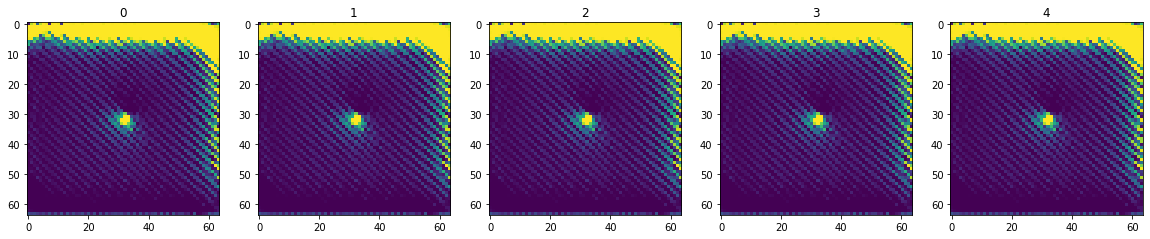

In [66]:
images = galaxy_gan.generator.predict(tf.random.uniform((5, 128, 1)))
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for i in range(5):
    ax[i].imshow(np.squeeze(images[i]))
    ax[i].title.set_text(i)

In [67]:
galaxy_gan.compile(g_opt, d_opt, g_loss, d_loss)

### 3.3. Callbacks

In [68]:
from tensorflow.keras.preprocessing.image import array_to_img
from keras.callbacks import Callback

In [69]:
LAST_EPOCH=623

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{LAST_EPOCH+epoch}_{i}.png'))
            
        self.model.generator.save(os.path.join('models', 'generator'))
        self.model.discriminator.save(os.path.join('models', 'discriminator'))

### 3.4. Train

For 6 hours we can do roughly 21 epochs

In [70]:
import tensorflow
tensorflow.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [71]:
hist = galaxy_gan.fit(real_images, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10


2022-11-06 10:01:53.236939: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-06 10:01:53.237141: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-06 10:01:53.939994: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-06 10:01:53.940063: W tensorflow/core/common_runtime/bfc_allocato

100/100 [==============================] - ETA: 0s - d_loss: 6.4777 - g_loss: 15.4787

100/100 [==============================] - 92s 855ms/step - d_loss: 6.4773 - g_loss: 15.4773
Epoch 2/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4839 - g_loss: 15.3344

100/100 [==============================] - 87s 866ms/step - d_loss: 6.4837 - g_loss: 15.3344
Epoch 3/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4801 - g_loss: 15.3337

100/100 [==============================] - 87s 870ms/step - d_loss: 6.4805 - g_loss: 15.3337
Epoch 4/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4824 - g_loss: 15.3341

100/100 [==============================] - 87s 867ms/step - d_loss: 6.4820 - g_loss: 15.3340
Epoch 5/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4874 - g_loss: 15.3347

100/100 [==============================] - 87s 868ms/step - d_loss: 6.4867 - g_loss: 15.3347
Epoch 6/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4766 - g_loss: 15.3349

100/100 [==============================] - 87s 867ms/step - d_loss: 6.4772 - g_loss: 15.3349
Epoch 7/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4841 - g_loss: 15.3351

100/100 [==============================] - 87s 867ms/step - d_loss: 6.4843 - g_loss: 15.3351
Epoch 8/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4815 - g_loss: 15.3360

100/100 [==============================] - 87s 868ms/step - d_loss: 6.4808 - g_loss: 15.3360
Epoch 9/10
 91/100 [==========================>...] - ETA: 7s - d_loss: 6.4799 - g_loss: 15.3359

2022-11-06 10:14:45.661477: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


100/100 [==============================] - ETA: 0s - d_loss: 6.4783 - g_loss: 15.3360

100/100 [==============================] - 87s 867ms/step - d_loss: 6.4786 - g_loss: 15.3360
Epoch 10/10
100/100 [==============================] - ETA: 0s - d_loss: 6.4755 - g_loss: 15.3361

100/100 [==============================] - 87s 867ms/step - d_loss: 6.4755 - g_loss: 15.3360


## 4. Testing

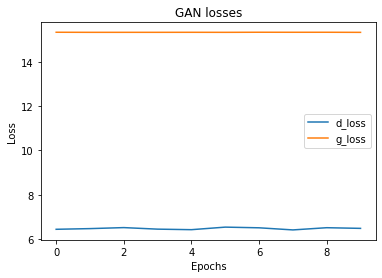

In [72]:
plt.plot(hist.history['d_loss'], label="d_loss")
plt.plot(hist.history['g_loss'], label="g_loss")
plt.title('GAN losses')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 [==============================] - 0s 17ms/step


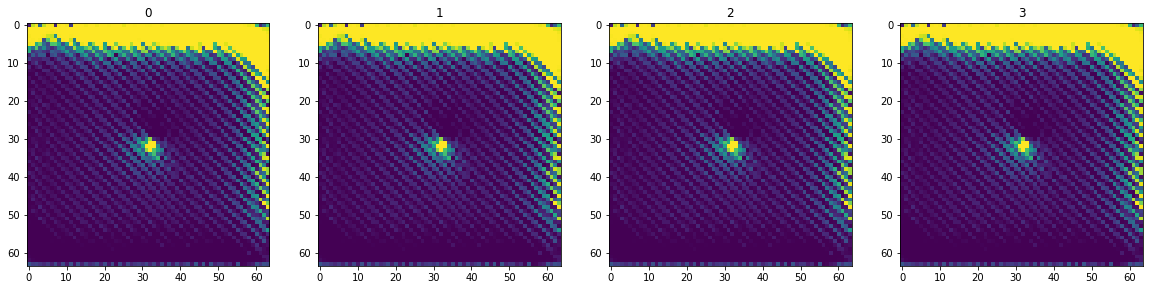

In [73]:
images = galaxy_gan.generator.predict(tf.random.normal((4, 128, 1)))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    ax[i].imshow(np.squeeze(images[i]))
    ax[i].title.set_text(i)

In [74]:
generator.save(os.path.join('models', 'generator.h5'))
discriminator.save(os.path.join('models', 'discriminator.h5'))